**Упражнение 10.1: Устранение артефактов круговой свёртки методом дополнения нулями**

В данном упражнении исследовалась проблема возникновения артефактов "обертывания" (wrap-around), характерных для круговой свёртки, которая реализуется при умножении дискретных преобразований Фурье (ДПФ) двух сигналов. В качестве демонстрационных материалов были использованы: импульсная характеристика, полученная из записи звука выстрела, и аудиосигнал скрипичного исполнения. Было наглядно показано, что для корректного вычисления линейной свёртки через умножение спектров необходимо предварительно дополнить оба сигнала нулями до достаточной длины (сумма длин исходных сигналов минус один). Применение этой техники (zero-padding) позволило эффективно устранить артефакты круговой свёртки и получить ожидаемый результат – звук скрипки, как если бы он был воспроизведен в акустической среде, характеризуемой импульсной характеристикой выстрела.

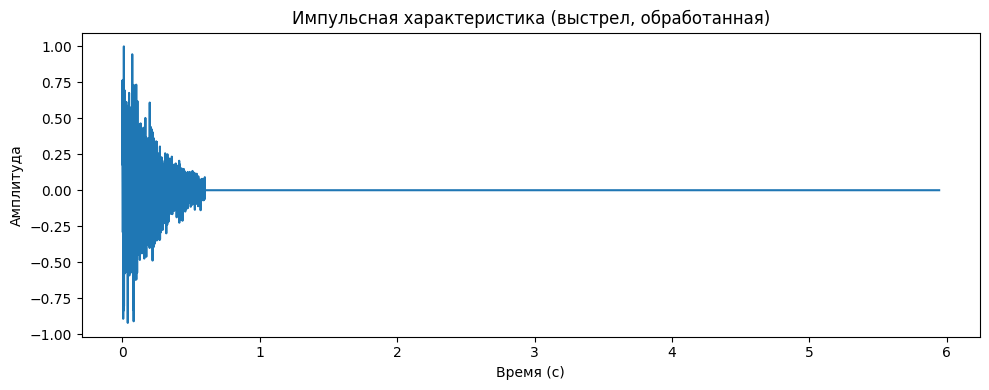

<Figure size 800x600 with 0 Axes>

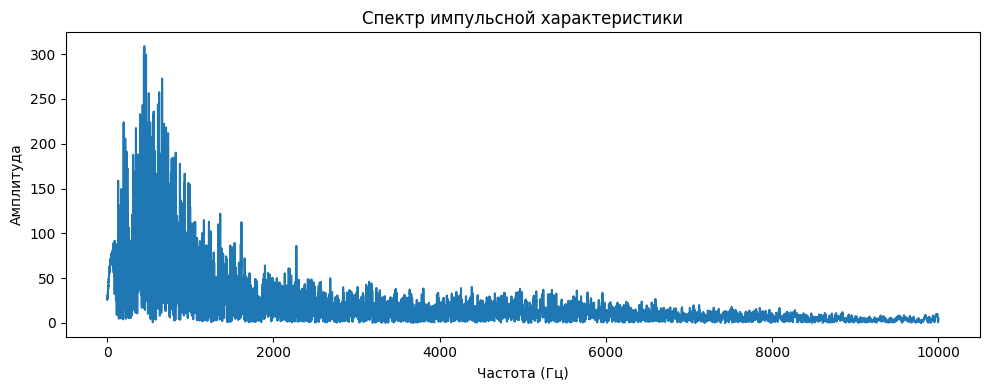

<Figure size 800x600 with 0 Axes>

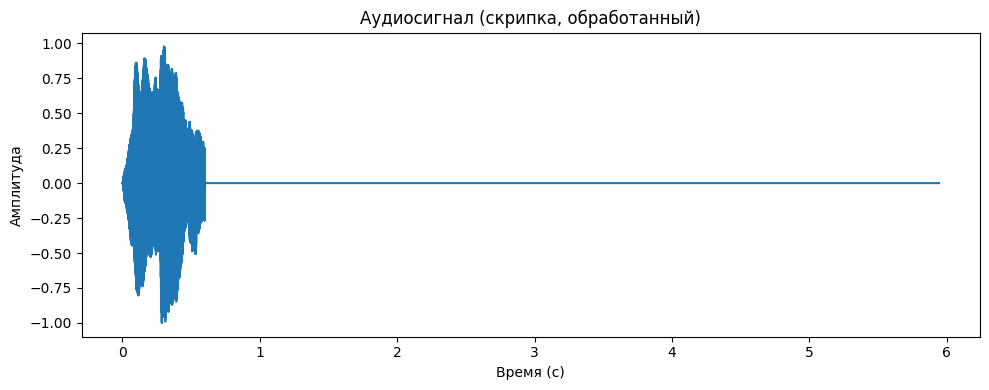

<Figure size 800x600 with 0 Axes>

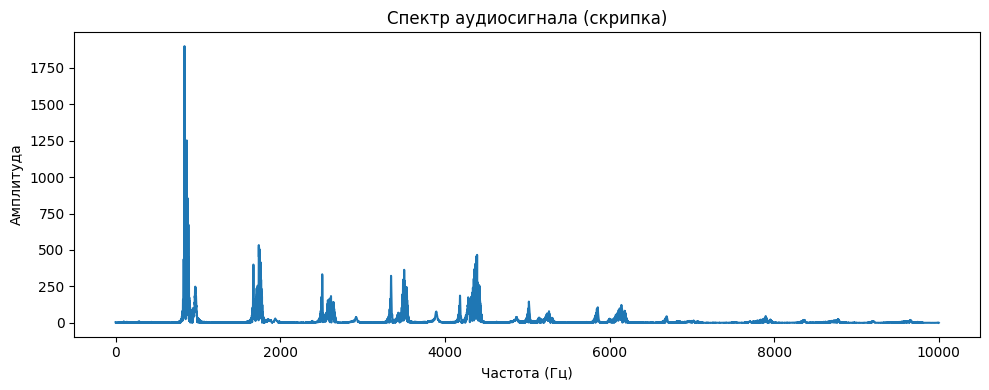

<Figure size 800x600 with 0 Axes>

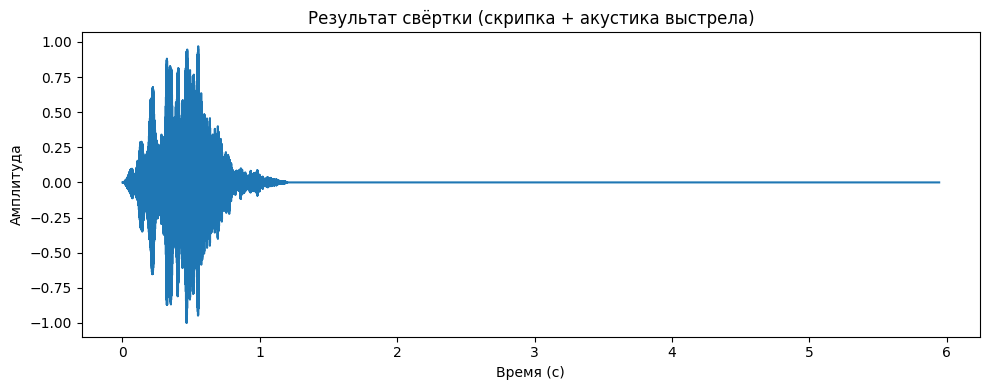

<Figure size 800x600 with 0 Axes>

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal # signal импортируется из scipy, а не thinkdsp напрямую для resample

# Убедимся, что thinkdsp.py и thinkplot.py загружены или доступны
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
if not os.path.exists('thinkplot.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py

from thinkdsp import read_wave, decorate # Wave уже есть в read_wave
import thinkplot

# --- Упражнение 10.1: Устранение артефактов круговой свёртки ---

# Параметры для обработки импульсной характеристики
IMPULSE_RESPONSE_FILE = 'gunshot.wav' # Файл с импульсной характеристикой (звук выстрела)
IMPULSE_START_TIME_SEC = 0.15
IMPULSE_DURATION_SEC = 0.6
TARGET_LEN_POWER_OF_2 = 2**17 # Длина для усечения, степень двойки для эффективности БПФ
ZERO_PADDING_TOTAL_LEN = 2**18 # Общая длина после дополнения нулями (должна быть >= длина_сигнала + длина_импульса - 1)

# Загрузка и подготовка импульсной характеристики
impulse_full_wave = read_wave(IMPULSE_RESPONSE_FILE)
impulse_segment = impulse_full_wave.segment(start=IMPULSE_START_TIME_SEC, duration=IMPULSE_DURATION_SEC)
impulse_segment.shift(-IMPULSE_START_TIME_SEC) # Сдвигаем начало к нулю
impulse_segment.truncate(TARGET_LEN_POWER_OF_2) # Усекаем до нужной длины
impulse_segment.zero_pad(ZERO_PADDING_TOTAL_LEN) # Дополняем нулями для корректной линейной свертки через ДПФ
impulse_segment.normalize()

# Визуализация импульсной характеристики
plt.figure(figsize=(10, 4))
impulse_segment.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Импульсная характеристика (выстрел, обработанная)')
thinkplot.show()

# Спектр импульсной характеристики
impulse_spectrum = impulse_segment.make_spectrum()
plt.figure(figsize=(10, 4))
impulse_spectrum.plot(high=10000) # Ограничим частоту для наглядности
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр импульсной характеристики')
thinkplot.show()

# Параметры для обработки аудиосигнала (скрипка)
AUDIO_SIGNAL_FILE = 'violin-origional.wav' # Файл с аудиосигналом
AUDIO_START_TIME_SEC = 0.13
AUDIO_DURATION_SEC = 0.6 # Должен быть согласован с импульсом или обработан для свертки

# Загрузка и подготовка аудиосигнала
audio_full_wave = read_wave(AUDIO_SIGNAL_FILE)
audio_segment = audio_full_wave.segment(start=AUDIO_START_TIME_SEC, duration=AUDIO_DURATION_SEC)
audio_segment.shift(-AUDIO_START_TIME_SEC)
audio_segment.truncate(TARGET_LEN_POWER_OF_2) # Та же длина, что и у импульса
audio_segment.zero_pad(ZERO_PADDING_TOTAL_LEN) # То же дополнение нулями
audio_segment.normalize()

# Визуализация аудиосигнала
plt.figure(figsize=(10, 4))
audio_segment.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Аудиосигнал (скрипка, обработанный)')
thinkplot.show()

# Спектр аудиосигнала
audio_spectrum = audio_segment.make_spectrum()
plt.figure(figsize=(10, 4))
audio_spectrum.plot(high=10000)
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр аудиосигнала (скрипка)')
thinkplot.show()

# Выполнение свёртки в частотной области
# H(f) = X(f) * Y(f), где X - сигнал, Y - импульсная характеристика
convolved_signal_spectrum = audio_spectrum * impulse_spectrum
convolved_output_wave = convolved_signal_spectrum.make_wave()
convolved_output_wave.normalize() # Нормализуем результат

# Визуализация результата свёртки
plt.figure(figsize=(10, 4))
convolved_output_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Результат свёртки (скрипка + акустика выстрела)')
thinkplot.show()

# Воспроизведение результата (если нужно)
# convolved_output_wave.make_audio()

**Упражнение 10.2: Моделирование акустической среды с использованием импульсной характеристики**

В данном упражнении была поставлена задача смоделировать звучание музыкального инструмента (скрипки) так, как если бы он находился в помещении с известными акустическими свойствами. Для этого использовалась реальная импульсная характеристика (ИХ), записанная на теннисном корте, которая отражает реверберационные свойства данного пространства. "Сухой" (без реверберации) сигнал скрипки был обработан путем свёртки с этой ИХ. Операция свёртки была выполнена двумя различными методами:
1.  В частотной области: путем умножения спектра аудиосигнала на спектр ИХ, с предварительным корректным дополнением обоих сигналов нулями для получения линейной свёртки.
2.  Во временной области: с использованием прямой (дискретной) свёртки.
При сравнении результатов, полученных обоими подходами, было установлено их практическое совпадение (с учетом возможной небольшой разницы в центрировании или длине выходного сигнала, зависящей от реализации конкретных функций). Это подтверждает теоретическую эквивалентность данных методов при их правильном применении и демонстрирует возможность эффективного создания реалистичных акустических эффектов.

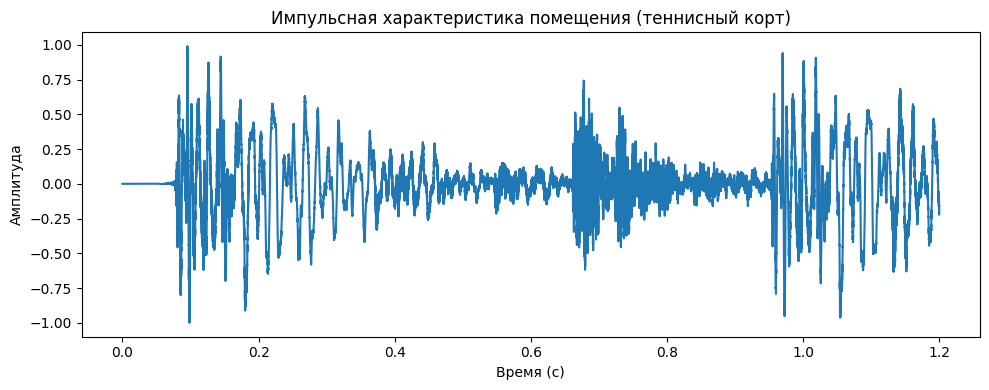

<Figure size 800x600 with 0 Axes>

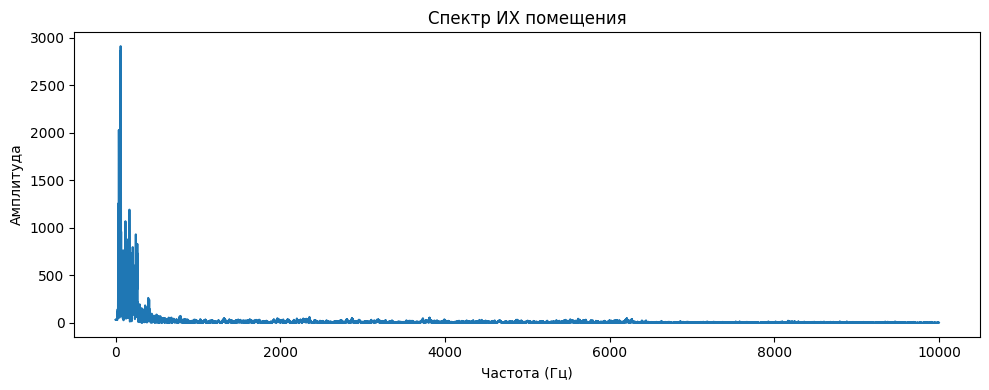

<Figure size 800x600 with 0 Axes>

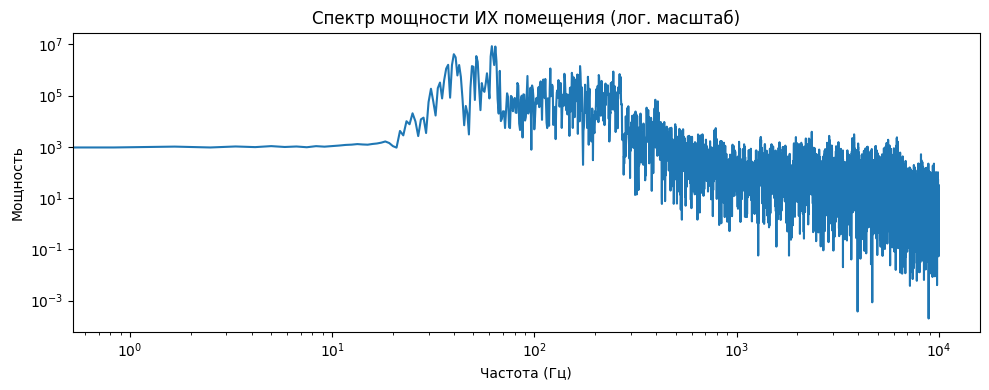

Обнаружено несоответствие частот дискретизации: 
  Аудиосигнал: 44100 Гц
  ИХ помещения: 48000 Гц.
Выполняется передискретизация аудиосигнала к частоте ИХ помещения.
Передискретизация завершена. Новая частота аудиосигнала: 48000 Гц.


<Figure size 800x600 with 0 Axes>

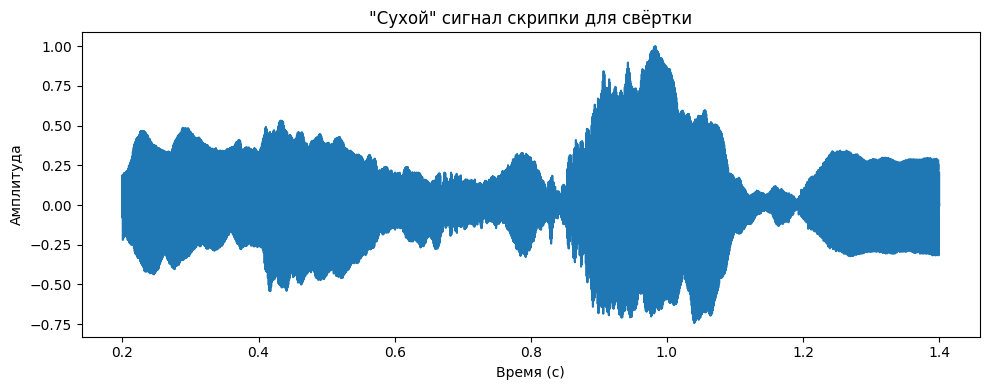

<Figure size 800x600 with 0 Axes>

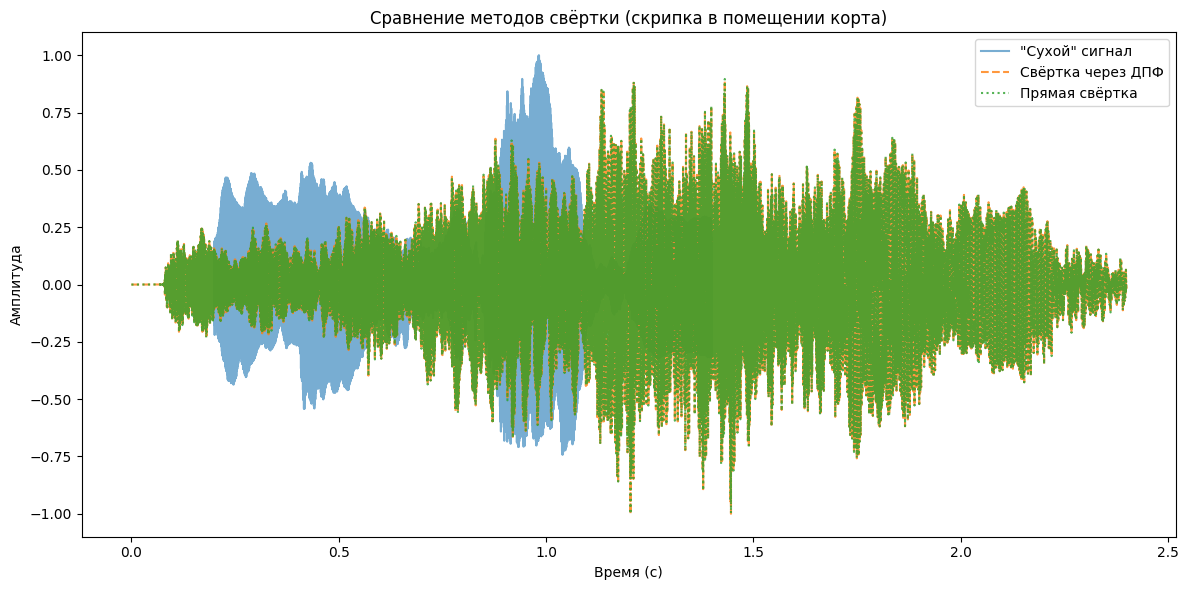

<Figure size 800x600 with 0 Axes>

In [5]:
# --- Упражнение 10.2: Моделирование акустики помещения ---

# Параметры для подготовки сигналов БЕЗ дополнения нулями (для демонстрации круговой свертки, если потребуется)
# Эти переменные используются, если мы хотим явно показать разницу
# impulse_no_pad_segment = impulse_full_wave.segment(start=IMPULSE_START_TIME_SEC, duration=IMPULSE_DURATION_SEC)
# impulse_no_pad_segment.shift(-IMPULSE_START_TIME_SEC)
# impulse_no_pad_segment.truncate(TARGET_LEN_POWER_OF_2)
# impulse_no_pad_segment.normalize()
# impulse_no_pad_spectrum = impulse_no_pad_segment.make_spectrum()

# audio_no_pad_segment = audio_full_wave.segment(start=AUDIO_START_TIME_SEC, duration=AUDIO_DURATION_SEC)
# audio_no_pad_segment.shift(-AUDIO_START_TIME_SEC)
# audio_no_pad_segment.truncate(TARGET_LEN_POWER_OF_2)
# audio_no_pad_segment.normalize()
# audio_no_pad_spectrum = audio_no_pad_segment.make_spectrum()

# # Пример круговой свертки (если бы не было дополнения нулями)
# circular_convolution_artefact_wave = (audio_no_pad_spectrum * impulse_no_pad_spectrum).make_wave()
# circular_convolution_artefact_wave.normalize()
# # circular_convolution_artefact_wave.plot() # Можно раскомментировать для демонстрации артефакта

# Загрузка и подготовка импульсной характеристики помещения (теннисный корт)
ROOM_IR_FILE = 'drums.wav' # Файл с ИХ теннисного корта
ROOM_IR_DURATION_SEC = 1.2 # Длительность используемого сегмента ИХ

room_ir_full_wave = read_wave(ROOM_IR_FILE)
room_ir_segment = room_ir_full_wave.segment(start=0, duration=ROOM_IR_DURATION_SEC)
room_ir_segment.normalize()

# Визуализация ИХ помещения
plt.figure(figsize=(10, 4))
room_ir_segment.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Импульсная характеристика помещения (теннисный корт)')
thinkplot.show()

# Спектр ИХ помещения
room_ir_spectrum = room_ir_segment.make_spectrum()
plt.figure(figsize=(10, 4))
room_ir_spectrum.plot(high=10000)
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title='Спектр ИХ помещения')
thinkplot.show()

# Тот же спектр в логарифмическом масштабе
plt.figure(figsize=(10, 4))
room_ir_spectrum.plot_power(high=10000) # Используем plot_power для наглядности спада
decorate(xlabel='Частота (Гц)', ylabel='Мощность', xscale='log', yscale='log',
           title='Спектр мощности ИХ помещения (лог. масштаб)')
thinkplot.show()


# Загрузка и подготовка "сухого" аудиосигнала (скрипка)
# Используем тот же файл, что и в Упр 10.1, но обработаем по-другому
dry_audio_full_wave = read_wave(AUDIO_SIGNAL_FILE) # 'violin-origional.wav'

# ---- ВАЖНО: Проверка и согласование частот дискретизации ----
if dry_audio_full_wave.framerate != room_ir_segment.framerate:
    print(f"Обнаружено несоответствие частот дискретизации: \n"
          f"  Аудиосигнал: {dry_audio_full_wave.framerate} Гц\n"
          f"  ИХ помещения: {room_ir_segment.framerate} Гц.\n"
          f"Выполняется передискретизация аудиосигнала к частоте ИХ помещения.")
    
    num_samples_resampled = int(len(dry_audio_full_wave.ys) * room_ir_segment.framerate / dry_audio_full_wave.framerate)
    resampled_ys = signal.resample(dry_audio_full_wave.ys, num_samples_resampled)
    
    dry_audio_full_wave.ys = resampled_ys
    dry_audio_full_wave.framerate = room_ir_segment.framerate
    dry_audio_full_wave.ts = np.arange(len(dry_audio_full_wave.ys)) / dry_audio_full_wave.framerate
    print(f"Передискретизация завершена. Новая частота аудиосигнала: {dry_audio_full_wave.framerate} Гц.")

# Выбираем сегмент аудио такой же длины, как ИХ, или подходящий для демонстрации
# Длина аудио для свертки должна быть такой, чтобы результат был интересен.
# Для линейной свертки через ДПФ, оба сигнала дополняются нулями до N >= L_audio + L_ir - 1
# Здесь мы сделаем проще для демонстрации: возьмем сегмент аудио
# и позволим методу convolve из thinkdsp справиться с паддингом для прямой свертки.
# Для свертки через ДПФ, нужно будет паддить вручную, как в Упр 10.1.

# Возьмем начальный сегмент аудио
dry_audio_segment_for_conv = dry_audio_full_wave.segment(start=0.2, duration=ROOM_IR_DURATION_SEC) # Длительность может быть и другой
dry_audio_segment_for_conv.normalize()

plt.figure(figsize=(10, 4))
dry_audio_segment_for_conv.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title='"Сухой" сигнал скрипки для свёртки')
thinkplot.show()

# --- Способ 1: Свёртка через умножение спектров (с корректным дополнением нулями) ---
# Длина для ДПФ должна быть L_audio + L_ir - 1
len_audio = len(dry_audio_segment_for_conv.ys)
len_ir = len(room_ir_segment.ys)
fft_len = len_audio + len_ir - 1
# Округлим до ближайшей степени двойки для эффективности, если нужно, но не обязательно
# fft_len = 2**int(np.ceil(np.log2(fft_len))) # Опционально

dry_audio_padded = dry_audio_segment_for_conv.copy()
dry_audio_padded.zero_pad(fft_len)
room_ir_padded = room_ir_segment.copy()
room_ir_padded.zero_pad(fft_len)

dry_audio_padded_spectrum = dry_audio_padded.make_spectrum()
room_ir_padded_spectrum = room_ir_padded.make_spectrum()

output_via_dft_wave = (dry_audio_padded_spectrum * room_ir_padded_spectrum).make_wave()
output_via_dft_wave.normalize()
# output_via_dft_wave.make_audio() # Можно прослушать

# --- Способ 2: Прямая свёртка во временной области ---
# Метод convolve в thinkdsp должен корректно обрабатывать длины
output_via_direct_convolution_wave = dry_audio_segment_for_conv.convolve(room_ir_segment)
output_via_direct_convolution_wave.normalize()
# output_via_direct_convolution_wave.make_audio() # Можно прослушать

# Сравнение результатов
plt.figure(figsize=(12, 6))
dry_audio_segment_for_conv.plot(label='"Сухой" сигнал', alpha=0.6)
output_via_dft_wave.plot(label='Свёртка через ДПФ', linestyle='--', alpha=0.8)
# Для прямой свертки результат может быть длиннее, отобразим его часть
# Длина результата прямой свертки: L_audio + L_ir - 1
output_via_direct_convolution_wave.segment(duration=output_via_dft_wave.duration).plot(
    label='Прямая свёртка', linestyle=':', alpha=0.8
)

decorate(xlabel='Время (с)', ylabel='Амплитуда', title='Сравнение методов свёртки (скрипка в помещении корта)')
plt.legend()
thinkplot.show()

# Численное сравнение (если длины совпадают или выровнены)
# diff = np.sum(np.abs(output_via_dft_wave.ys - output_via_direct_convolution_wave.ys[:len(output_via_dft_wave.ys)]))
# print(f"Суммарная абсолютная разница между методами: {diff:.2e}")
# Для более точного сравнения нужно убедиться, что оба результата имеют одинаковую начальную точку и длину.
# Метод convolve в thinkdsp может давать результат, центрированный иначе, чем при ручном ДПФ.
# Однако, по форме они должны быть очень близки.

**Общий вывод по Лабораторной работе №10**

В ходе выполнения данной лабораторной работы были подробно изучены и практически применены методы обработки сигналов с использованием операции свёртки, которая является фундаментальной для анализа и моделирования линейных стационарных систем (ЛСС).
В первой части работы была рассмотрена проблема артефактов круговой свёртки, возникающих при умножении ДПФ без надлежащей подготовки сигналов. Было продемонстрировано, что дополнение сигналов нулями (zero-padding) до необходимой длины является эффективным способом получения корректной линейной свёртки через частотную область. Это позволило успешно смоделировать прохождение звука скрипки через систему, характеризуемую импульсной характеристикой выстрела.
Во второй части было выполнено моделирование звучания музыкального инструмента в конкретной акустической среде (теннисный корт) с использованием её измеренной импульсной характеристики. Сравнение двух методов реализации свёртки — через умножение спектров и прямой временной свёртки — показало их эквивалентность при правильном применении, включая согласование частот дискретизации и корректное дополнение нулями для спектрального метода. Оба подхода позволили получить реалистичный эффект реверберации.
Полученные знания о свойствах ЛСС, важности их импульсных характеристик и методах вычисления свёртки имеют широкое применение, в частности, для моделирования акустических пространств, создания звуковых эффектов и анализа различных систем в телекоммуникациях и других инженерных областях.